In [2]:
#d=["iwc","dm","attKu","attKa",knn]
import pickle
#read data from knn_impacts2020_Kuo.pklz
#pickle.dump(d,open("knn_impacts2020_Kuo.pklz",'wb'))
d=pickle.load(open("knn_impacts2020_Kuo.pklz",'rb'))
knn=d[4]

In [65]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
with nc.Dataset('/Users/mgrecu/WDomains/IMPACTS_20230217/wrfout_d02_2023-02-17_01:00:00') as f:
    lon=f.variables['XLONG'][0,:,:]
    lat=f.variables['XLAT'][0,:,:]
    qrain=f.variables['QRAIN'][:,:,:]
    ncrain=f.variables['QNRAIN'][:,:,:]
    qice=f.variables['QICE'][:,:,:]
    ncice=f.variables['QNICE'][:,:,:]
    qir=f.variables['QIR'][:,:,:]
    xlon=f.variables['XLONG'][0,:,:]
    xlat=f.variables['XLAT'][0,:,:]
    height=f.variables['PHB'][:,:,:,:]+f.variables['PH'][:,:,:,:]
    sfc_height=f.variables['HGT'][0,:,:]
    theta=f.variables['T'][:,:,:,:]+300.
    p=f.variables['P'][:,:,:,:]+f.variables['PB'][:,:,:,:]
    rainnc=f.variables['RAINNC'][:,:,:]
    t=theta*(p/100000.)**0.286
    rho=p/(287.*t)
    qv=f.variables['QVAPOR'][:,:,:]

In [74]:
iwp=np.zeros((qrain.shape[0],qrain.shape[2],qrain.shape[3]),float)
for i in range(qrain.shape[0]):
    dz=(height[i,1:,:,:]-height[i,:-1,:,:])/9.81
    iwp[i,:,:]=np.sum(qice[i,:,:,:]*rho[i,:,:,:]*1e3*dz,axis=0)

(18, 123, 105)


/Users/mgrecu/miniconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


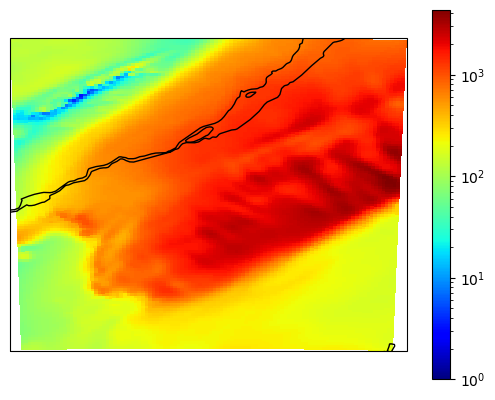

In [81]:
ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.pcolormesh(lon,lat,iwp[-3,:,:],transform=ccrs.PlateCarree(),cmap='jet',norm=colors.LogNorm(vmin=1))
plt.colorbar()
print(iwp.shape)

# save iwp to a netcdf file using xarray

import xarray as xr
import numpy as np
iwpX=xr.DataArray(iwp[-6:,:,:][::-1,:,:],dims=['time','ny','nx'],coords={'time':np.arange(6),'ny':range(iwp.shape[1]),'nx':range(iwp.shape[2])})
lonX=xr.DataArray(lon,dims=['ny','nx'],coords={'ny':range(lon.shape[0]),'nx':range(lon.shape[1])})
latX=xr.DataArray(lat,dims=['ny','nx'],coords={'ny':range(lat.shape[0]),'nx':range(lat.shape[1])})
ds=xr.Dataset({'iwp':iwpX,'lat':latX,'lon':latX})
ds.to_netcdf('iwp_20230217.nc',encoding={'iwp':{'zlib':True,'complevel':5}})


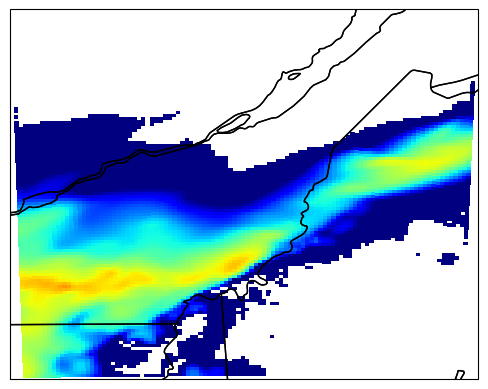

In [25]:
import cartopy.crs as ccrs
import cartopy
ax=plt.axes(projection=ccrs.PlateCarree())
import matplotlib.colors as colors
ax.pcolormesh(lon,lat,qrain[0,:,:],cmap='jet',norm=colors.LogNorm(vmin=1e-6,vmax=1e-3))
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)


In [62]:
import scatterLib as libSc
ny,nx=qrain.shape[-2:]
it=-1

#print(a.shape)
print(nx*ny)
rhoice=100.0
nz=qrain.shape[1]
nz80=80
qice_1d=np.zeros((nz80),float)
dmice_1d=np.zeros((nz80),float)
qrain_1d=np.zeros((nz80),float)
ncice_1d=np.zeros((nz80),float)
zKuSim=np.zeros((nz80),float)
zKaSim=np.zeros((nz80),float)
zKu_true=np.zeros((nz80),float)
zKa_true=np.zeros((nz80),float)
nt,nz,ny,nx=qrain.shape
piaKu2D=np.zeros((ny,nx),float)
piaKa2D=np.zeros((ny,nx),float)
nfreqm=8
nt=6
kext3D=np.zeros((nt,nz80,ny,nx,nfreqm),float)
salb3D=np.zeros((nt,nz80,ny,nx,nfreqm),float)
asym3D=np.zeros((nt,nz80,ny,nx,nfreqm),float)
t3D=np.zeros((nt,nz80+1,ny,nx),float)
btemp2d=np.zeros((nt,ny,nx),float)
cossir_freqs=[94.0,170.0,177.0,180.,182.,325.0+11,325.0+3,325.0+1]
nfreqm=len(cossir_freqs)
for it1 in range(nt):
    it=-1-it1
    a=np.nonzero(qrain[it,0,:,:]>-1e-5)
    for i,j in zip(a[0],a[1]):
        qice_1dtmp=qice[it,:,i,j].copy()
        qrain_1dtmp=qrain[it,:,i,j].copy()
        dmice_1dtmp=qice[it,:,i,j].copy()*0
        dmrain_1dtmp=qrain[it,:,i,j].copy()*0
        hm=(height[it,1:,i,j]+height[it,:-1,i,j])/2/9.81e3
        hgrid=height[it,0,i,j]/9.81e3+np.arange(nz80)*0.25+0.125
        kextAtmAllFreq=[]
        for freq in cossir_freqs:
            kextatm=[]
            for k1 in range(nz):
                ireturn=0
                absair,abswv = libSc.gasabsr98(freq,t[it,k1,i,j],qv[it,k1,i,j]*rho[it,k1,i,j],p[it,k1,i,j],ireturn)
                kextatm.append(absair+abswv)
            kextAtmAllFreq.append(kextatm)
        kextAtmAllFreq=np.array(kextAtmAllFreq).T
        
        dr=0.25
        for k1 in range(nz80-1,-1,-1):
            attKu=0
            attKa=0
            zku=0
            zka=0
        #dmice_1d[k1]=max(lkTables.dms[0],dmice_1d[k1])
        #dmice_1d[k1]=min(dmice_1d[k1],lkTables.dms[-1])
        #dmrain_1d[k1]=max(lkTables.dmr[0],dmrain_1d[k1])
        #dmrain_1d[k1]=min(dmrain_1d[k1],lkTables.dmr[-1])
        #if iwc_1d[k1]>0:
            #ind=bisectm(lkTables.gwc.data,272,gwc[k1]/10**dng)
        #    ind=bisectm(lkTables.dms.data,253,dmice_1d[k1])
        #    dn_ice=np.log10(iwc_1d[k1]/lkTables.gwc.data[ind])
        #    zKu_ice=lkTables.zKuS[ind]+10*dn_ice
        #    zKa_ice=lkTables.zKaS[ind]+10*dn_ice
        #    attKu_ice=lkTables.attKuS[ind]*10**dn_ice
        #    attKa_ice=lkTables.attKaS[ind]*10**dn_ice
        #    attKu+=attKu_ice
        #    attKa+=attKa_ice
        #    zku+=10**(0.1*zKu_ice)
        #    zka+=10**(0.1*zKa_ice)
        #    kext1D[k1,:]+=lkTables.kextS[ind,:]*10**dn_ice
        #    salb1D[k1,:]+=lkTables.kextS[ind,:]*10**dn_ice*lkTables.salbS[ind,:]
        #    asym1D[k1,:]+=lkTables.kextS[ind,:]*10**dn_ice*lkTables.salbS[ind,:]*lkTables.asymS[ind,:]
        
        #if rwc_1d[k1]>0:
        #    ind=bisectm(lkTables.dmr.data,289,dmrain_1d[k1])
        #    dnr=np.log10(rwc_1d[k1]/lkTables.rwc.data[ind])
        #    zKur=lkTables.zKuR[ind]+10*dnr
        #    zKar=lkTables.zKaR[ind]+10*dnr
        #    attKur=lkTables.attKuR[ind]*10**dnr
        #    attKar=lkTables.attKaR[ind]*10**dnr
        #    attKu+=attKur
        #    attKa+=attKar
        #    zku+=10**(0.1*zKur)
        #    zka+=10**(0.1*zKar)
        #    kext1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr
        #    salb1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr*lkTables.salbR[ind,:]
        #    asym1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr*lkTables.salbR[ind,:]*lkTables.asymR[ind,:]
        #if attKu>0:
        #    piaKu+=attKu*dr
        #    piaKa+=attKa*dr
        #    zKuSim[k1]=10*np.log10(zku)-piaKu
        #    zKaSim[k1]=10*np.log10(zka)-piaKa
        #    zKu_true[k1]=10*np.log10(zku)
        #    zKa_true[k1]=10*np.log10(zka)
        #    piaKu+=attKu*dr
        #    piaKa+=attKa*dr
    #piaKu2D[i,j]=piaKu
    #piaKa2D[i,j]=piaKa
    #umu=np.cos(53/180*3.1415)
        btemp=t[it,0,i,j]
        nz81=nz80+1
        hgrid1=height[it,0,i,j]/9.81e3+np.arange(nz81)*0.25
        lyrtemp=np.interp(hgrid1,hm,t[it,:,i,j])
    #lyrhgt=hgrid1
    #tboutL=[]
        for ifreq in range(nfreqm):
            kext=np.interp(hgrid,hm,kextAtmAllFreq[:,ifreq])
    #    salb=salb1D[:,ifreq]
    #    asym=asym1D[:,ifreq]
    #    asalb=np.nonzero(salb>1e-3)
    #    asym[asalb]=asym[asalb]/salb[asalb]
    #    salb/=kext
    #    fisot=2.7
    #    emis=0.98
    #    ebar=0.98
    #    tbout = libSc.radtran(umu,btemp,lyrtemp,lyrhgt,kext,salb,asym,fisot,emis,ebar)
    #    tboutL.append(tbout)
            kext3D[it,:,i,j,ifreq]=kext
        #salb3D[:,i,j,ifreq]=salb
        #asym3D[:,i,j,ifreq]=asym
            t3D[it,:,i,j]=lyrtemp
            btemp2d[it,i,j]=btemp
    #break
    #break

12915


In [63]:
import xarray as xr

ds=xr.Dataset({'kext':(['time','z','y','x','freq'],kext3D[:,:,:,:,:nfreqm]),
                't':(['time','z1','y','x'],t3D),
                'btemp':(['time','y','x'],btemp2d),
                'lat':(['y','x'],lat),
                'lon':(['y','x'],lon)},
                  coords={'time':(['time'],np.arange(nt)),
                         'z':(['z'],hgrid),
                         'y':(['y'],range(ny)),
                         'x':(['x'],range(nx)),
                         'freq':(['freq'],cossir_freqs)})

In [64]:
ds.to_netcdf('kextEnv_t_btemp_20230217.nc',encoding={'kext':{'zlib':True,'complevel':5,'dtype':'float32'},
                                                        't':{'zlib':True,'complevel':5,'dtype':'float32'},
                                                        'btemp':{'zlib':True,'complevel':5,'dtype':'float32'},
                                                        'lat':{'zlib':True,'complevel':5,'dtype':'float32'},
                                                        'lon':{'zlib':True,'complevel':5,'dtype':'float32'}})

In [41]:
with nc.Dataset('scatPropSSRG.nc') as f:
    dmR=f.variables['dmR'][:]
    dmI=f.variables['dmI'][:]
    kScatR=f.variables['kScatR'][:]
    kScatI=f.variables['kScatI'][:]
    kExtR=f.variables['kExtR'][:]
    kExtI=f.variables['kExtI'][:]
    gR=f.variables['gR'][:]
    gI=f.variables['gI'][:]
    zR=f.variables['zR'][:]
    zI=f.variables['zI'][:]
    rwc=f.variables['rwc'][:]
    swc=f.variables['swc'][:]
    freqs=f.variables['freq'][:]
print(freq)
ifreqs=[4,1,2]
print(freqs[ifreqs])

[ 13.8  183.31 325.15  35.    94.  ]
[ 94.   183.31 325.15]


(5, 300)
<class 'numpy.ma.core.MaskedArray'>


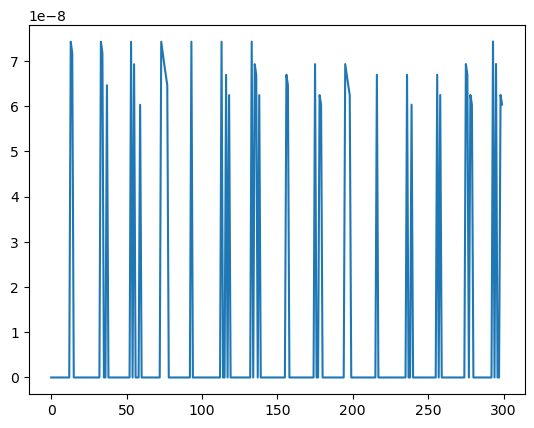

In [51]:
print(swc.shape)
plt.plot(swc.std(axis=0)/swc.mean(axis=0))
print(type(dmI[0,:]))
dmI=dmI.data
dmR=dmR.data

In [59]:
import scatterLib as libSc
ny,nx=qrain.shape[-2:]
it=-1
from bisectm import bisectm

#print(a.shape)
print(nx*ny)
rhoice=100.0
nz=qrain.shape[1]
nz80=80
qice_1d=np.zeros((nz80),float)
dmice_1d=np.zeros((nz80),float)
qrain_1d=np.zeros((nz80),float)
dmrain_1d=np.zeros((nz80),float)
#ncice_1d=np.zeros((nz80),float)
zKuSim=np.zeros((nz80),float)
zKaSim=np.zeros((nz80),float)
zKu_true=np.zeros((nz80),float)
zKa_true=np.zeros((nz80),float)
nt,nz,ny,nx=qrain.shape
piaKu2D=np.zeros((ny,nx),float)
piaKa2D=np.zeros((ny,nx),float)
nfreqm=3
nt=6
kext3D=np.zeros((nt,nz80,ny,nx,nfreqm),float)
salb3D=np.zeros((nt,nz80,ny,nx,nfreqm),float)
asym3D=np.zeros((nt,nz80,ny,nx,nfreqm),float)
t3D=np.zeros((nt,nz80+1,ny,nx),float)
btemp2d=np.zeros((nt,ny,nx),float)
cossir_freqs=[94.0,170.0,180.,182.,325.0+11,325.0+3,325.0+1]
#nfreqm=len(cossir_freqs)
import tqdm
for it1 in tqdm.tqdm(range(nt)):
    it=-1-it1
    a=np.nonzero(qrain[it,0,:,:]>-1e-5)
    for i,j in zip(a[0],a[1]):
        qice_1dtmp=qice[it,:,i,j].copy()
        qrain_1dtmp=qrain[it,:,i,j].copy()
        dmice_1dtmp=qice[it,:,i,j].copy()*0
        dmrain_1dtmp=qrain[it,:,i,j].copy()*0
        hm=(height[it,1:,i,j]+height[it,:-1,i,j])/2/9.81e3
        hgrid=height[it,0,i,j]/9.81e3+np.arange(nz80)*0.25+0.125
        rwc_1d=np.interp(hgrid,hm,qrain[it,:,i,j]*rho[it,:,i,j]*1e3)
        iwc_1d=np.interp(hgrid,hm,qice[it,:,i,j]*rho[it,:,i,j]*1e3)
        kext1D=np.zeros((nz80,nfreqm),float)
        salb1D=np.zeros((nz80,nfreqm),float)
        asym1D=np.zeros((nz80,nfreqm),float)
        for k1 in range(nz-1,-1,-1):
            if(qice[it,k1,i,j]>1e-5):
                dmice=4/(ncice[it,k1,i,j]*3.1415*rhoice/qice[it,k1,i,j])**0.333*1e3
                dmice_1dtmp[k1]=dmice
            if(qrain[it,k1,i,j]>1e-5):
                dmrain=4/(ncrain[it,k1,i,j]*3.1415*1000/qrain[it,k1,i,j])**0.333*1e3
                dmrain_1dtmp[k1]=dmrain
        dr=0.25
        for k1 in range(nz80-1,-1,-1):
            attKu=0
            attKa=0
            zku=0
            zka=0

            dmice_1d[k1]=max(dmI[0,0],dmice_1d[k1])
            dmice_1d[k1]=min(dmice_1d[k1],dmI[0,-1])
            dmrain_1d[k1]=max(dmR[0,0],dmrain_1d[k1])
            dmrain_1d[k1]=min(dmrain_1d[k1],dmR[0,-1])
            if iwc_1d[k1]>0:
                ind=bisectm(dmI[0,:],300,dmice_1d[k1])
                dn_ice=np.log10(iwc_1d[k1]/swc[0,ind])
        #    zKu_ice=lkTables.zKuS[ind]+10*dn_ice
        #    zKa_ice=lkTables.zKaS[ind]+10*dn_ice
        #    attKu_ice=lkTables.attKuS[ind]*10**dn_ice
        #    attKa_ice=lkTables.attKaS[ind]*10**dn_ice
        #    attKu+=attKu_ice
        #    attKa+=attKa_ice
        #    zku+=10**(0.1*zKu_ice)
        #    zka+=10**(0.1*zKa_ice)
                kext1D[k1,:]+=kExtI[ifreqs,ind]*10**dn_ice
                salb1D[k1,:]+=kScatI[ifreqs,ind]*10**dn_ice
                asym1D[k1,:]+=gI[ifreqs,ind]*10**dn_ice*kScatI[ifreqs,ind]
        
            if rwc_1d[k1]>0:
                ind=bisectm(dmR[0,:],300,dmrain_1d[k1])
                dnr=np.log10(rwc_1d[k1]/rwc[0,ind])
                kext1D[k1,:]+=kExtR[ifreqs,ind]*10**dnr
                salb1D[k1,:]+=kScatR[ifreqs,ind]*10**dnr
                asym1D[k1,:]+=gR[ifreqs,ind]*10**dnr*kScatR[ifreqs,ind]
        # ind=bisectm(lkTables.dmr.data,289,dmrain_1d[k1])
        #    dnr=np.log10(rwc_1d[k1]/lkTables.rwc.data[ind])
        #    zKur=lkTables.zKuR[ind]+10*dnr
        #    zKar=lkTables.zKaR[ind]+10*dnr
        #    attKur=lkTables.attKuR[ind]*10**dnr
        #    attKar=lkTables.attKaR[ind]*10**dnr
        #    attKu+=attKur
        #    attKa+=attKar
        #    zku+=10**(0.1*zKur)
        #    zka+=10**(0.1*zKar)
        #    kext1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr
        #    salb1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr*lkTables.salbR[ind,:]
        #    asym1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr*lkTables.salbR[ind,:]*lkTables.asymR[ind,:]
        #if attKu>0:
        #    piaKu+=attKu*dr
        #    piaKa+=attKa*dr
        #    zKuSim[k1]=10*np.log10(zku)-piaKu
        #    zKaSim[k1]=10*np.log10(zka)-piaKa
        #    zKu_true[k1]=10*np.log10(zku)
        #    zKa_true[k1]=10*np.log10(zka)
        #    piaKu+=attKu*dr
        #    piaKa+=attKa*dr

    #    tboutL.append(tbout)
        kext3D[it,:,i,j,:]=kext1D
        salb3D[it,:,i,j,:]=salb1D
        asym3D[it,:,i,j,:]=asym1D
        
    #break
    #break

12915


100%|██████████| 6/6 [04:57<00:00, 49.54s/it]


In [61]:
ds=xr.Dataset({'kext':(['time','z','y','x','freq'],kext3D[:,:,:,:,:nfreqm]),
                'salb':(['time','z','y','x','freq'],salb3D[:,:,:,:,:nfreqm]),
                'asym':(['time','z','y','x','freq'],asym3D[:,:,:,:,:nfreqm]),
                'lat':(['y','x'],lat),
                'lon':(['y','x'],lon)},
                  coords={'time':(['time'],np.arange(nt)),
                         'z':(['z'],hgrid),
                         'y':(['y'],range(ny)),
                         'x':(['x'],range(nx)),
                         'freq':(['freq'],freqs[ifreqs])})

ds.to_netcdf('kextScatProp_hyd_20230217.nc',encoding={'kext':{'zlib':True,'complevel':5,'dtype':'float32'},
                                                        'salb':{'zlib':True,'complevel':5,'dtype':'float32'},
                                                        'asym':{'zlib':True,'complevel':5,'dtype':'float32'},
                                                        'lat':{'zlib':True,'complevel':5,'dtype':'float32'},
                                                        'lon':{'zlib':True,'complevel':5,'dtype':'float32'}})